In [401]:
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau, linregress
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import numpy as np
import piflib 
from piflib import compute_cigs
import warnings



# Suppress SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

# Activate pandas <-> R DataFrame conversion
pandas2ri.activate()

# Import the sdcMicro package
sdcMicro = importr('sdcMicro')

In [402]:
AOMIC = 'https://s3.amazonaws.com/openneuro.org/ds003097/participants.tsv?versionId=9gylMj_lF7dOQFiiUSuQ4OeHtgxzGUtv'
AOMIC = pd.read_csv(AOMIC, sep='\t')
AOMIC.to_csv('AOMIC_dataset_ds003097.csv', sep=',', index=False)

In [403]:
na_percentage = AOMIC.isna().mean() * 100
na_percentage = na_percentage[na_percentage >= 10].sort_values(ascending=False)
na_percentage

religious_importance    78.771552
sexual_attraction_M     40.301724
sexual_attraction_F     40.301724
gender_identity_M       40.301724
gender_identity_F       40.301724
dtype: float64

In [404]:
suda = pd.read_csv('data_ds003097/SUDA_ds003097.csv', sep=',')
pif = pd.read_csv('data_ds003097/PIF_ds003097.csv', sep=',',index_col='Unnamed: 0').sort_index()
suda_field_score =  pd.read_csv('data_ds003097/att_suda.csv', sep=',').drop(columns=['Unnamed: 0'], errors='ignore')
k_combined_field =  pd.read_csv('data_ds003097/normalized_difference.csv', sep=',').drop(columns=['Difference in Unique Rows','Unique Rows After Removal']).rename(columns={'Column': 'variable'})
k_combined_all = pd.read_csv('data_ds003097/k-combined-all-2-11.csv', sep=',')


In [405]:
AOMIC

participant_id    age     sex handedness  BMI education_level  \
0         sub-0001  22.00  female      right   23          medium   
1         sub-0002  21.75  female      right   20          medium   
2         sub-0003  25.25  female      right   31            high   
3         sub-0004  22.50  female      right   20            high   
4         sub-0005  22.25    male      right   23            high   
..             ...    ...     ...        ...  ...             ...   
923       sub-0924  22.25    male      right   21          medium   
924       sub-0925  25.25    male      right   30          medium   
925       sub-0926  20.75    male      right   22            high   
926       sub-0927  24.25  female      right   35          medium   
927       sub-0928  20.50    male       left   19            high   

     background_SES  IST_fluid  IST_memory  IST_crystallised  ...  \
0               2.0       77.0        49.0              33.0  ...   
1               5.5       97.0        63.0              39.0  ...   
2               3.0      122.0        67.0              38.0  ...   
3               5.0      149.0        69.0              52.0  ...   
4               4.5      112.0        57.0              43.0  ...   
..              ...        ...         ...               ...  ...   
923             3.0      136.0        56.0              54.0  ...   
924             4.0       64.0        37.0              49.0  ...   
925             2.0       84.0        44.0              33.0  ...   
926             2.5       98.0        57.0              35.0  ...   
927             5.0      135.0        59.0              49.0  ...   

     sexual_attraction_M  sexual_attraction_F  gender_identity_M  \
0                    7.0                  1.0                1.0   
1                    7.0                  1.0                2.0   
2                    6.0                  3.0                1.0   
3                    6.0                  2.0                1.0   
4                    1.0                  7.0                6.0   
..                   ...                  ...                ...   
923                  2.0                  6.0                4.0   
924                  1.0                  7.0                7.0   
925                  NaN                  NaN                NaN   
926                  7.0                  2.0                1.0   
927                  NaN                  NaN                NaN   

     gender_identity_F  religious_upbringing  religious_now  \
0                  7.0                    no            yes   
1                  7.0                    no             no   
2                  6.0                    no             no   
3                  7.0                   yes             no   
4                  1.0                    no             no   
..                 ...                   ...            ...   
923                4.0                    no             no   
924                1.0                    no             no   
925                NaN                   yes            yes   
926                7.0                    no             no   
927                NaN                    no             no   

     religious_importance  DWI_TR_run1  DWI_TR_run2  DWI_TR_run3  
0                     2.0        6.312        6.312        6.312  
1                     NaN          NaN        6.311        6.311  
2                     NaN        6.312        6.312        6.312  
3                     NaN        6.311        6.311        6.311  
4                     NaN        6.311        6.311        6.311  
..                    ...          ...          ...          ...  
923                   NaN        6.374        6.374        6.374  
924                   NaN        6.311        6.311        6.311  
925                   5.0        6.312        6.312        6.312  
926                   NaN        6.311        6.311        6.311  
927                   NaN        6.

In [406]:


def stats(suda, pif, suda_att, k_combined_field):
    
    
    print('\n' + '='*40)
    print('        ROW LEVEL CORRELATION      ')
    print('='*40 + '\n')
    
    
    # Spearman Rank Correlation
    correlation_spearman, _ = spearmanr(suda['dis-score'], pif['RIG'])
    print(f"Spearman Rank Correlation between suda & pif: {correlation_spearman:.2f}")  
    
    # Kendall's Tau Correlation
    tau, p_value = kendalltau(suda['dis-score'], pif['RIG'])
    print(f"Kendall's Tau between suda & pif: {tau:.2f}, p-value: {p_value:.4f}")
    
    # Pearson Correlation
    correlation_pearson = suda['dis-score'].corr(pif['RIG'])
    
    #field relationship
    
    sum_df = pif.drop(columns=['RIG']).sum()
    sum_df = pd.DataFrame(list(sum_df.items()), columns=['variable', 'sum'])
    
    
    # Merge the two DataFrames on 'variable'
    merged_field_values = pd.merge(suda_att, sum_df, on='variable')
    merged_field_values = pd.merge(merged_field_values, k_combined_field, on='variable') 
    


    # Calculate the correlation between 'contribution' and 'Sum'
    correlation_pif_suda = merged_field_values['contribution'].corr(merged_field_values['sum'])
    correlation_pif_k = merged_field_values['Normalized Difference'].corr(merged_field_values['sum'])
    correlation_suda_k = merged_field_values['contribution'].corr(merged_field_values['Normalized Difference'])

    
    
    
    
    # Plot with trend line
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(suda['dis-score'], pif['RIG'], alpha=0.3, label='Data Points')
    
    # Fit and plot the trend line
    slope, intercept, _, _, _ = linregress(suda['dis-score'], pif['RIG'])
    ax.plot(suda['dis-score'], slope * suda['dis-score'] + intercept, color='red', label='Trend Line')
    
    ax.set_title(f'Pearson Correlation: {correlation_pearson:.2f}')
    ax.set_xlabel('suda["dis-score"]')
    ax.set_ylabel('pif["RIG"]')
    ax.grid(False)
    ax.legend()
    
    plt.show()    
    plt.close(fig)
    print('____________________________________________________________________________________')
    
    print('\n' + '='*40)
    print('      FIELD LEVEL CORRELATIONS     ')
    print('='*40 + '\n')
    
    result_text_field_s_p = f"Pearson Correlation between SUDA & PIF field level: {correlation_pif_suda:.2f}"
    result_text_field_p_k = f"Pearson Correlation between K-combined & PIF field level: {correlation_pif_k:.2f}"
    result_text_field_s_k = f"Pearson Correlation between SUDA & K-combined field level: {correlation_suda_k:.2f}"

    print(result_text_field_s_p)
    print(result_text_field_p_k)
    print(result_text_field_s_k)
    
    print('\n')
    
    
    # Spearman correlation between PIF & SUDA
    correlation_spearman_pif_suda, _ = spearmanr(merged_field_values['contribution'], merged_field_values['sum'])
    print(f"Spearman Rank Correlation between PIF & SUDA: {correlation_spearman_pif_suda:.2f}")

    # Spearman correlation between PIF & K
    correlation_spearman_pif_k, _ = spearmanr(merged_field_values['Normalized Difference'], merged_field_values['sum'])
    print(f"Spearman Rank Correlation between PIF & K: {correlation_spearman_pif_k:.2f}")

    # Spearman correlation between SUDA & K
    correlation_spearman_suda_k, _ = spearmanr(merged_field_values['contribution'], merged_field_values['Normalized Difference'])
    print(f"Spearman Rank Correlation between SUDA & K: {correlation_spearman_suda_k:.2f}")

    return 



        ROW LEVEL CORRELATION      

Spearman Rank Correlation between suda & pif: 0.76
Kendall's Tau between suda & pif: 0.61, p-value: 0.0000


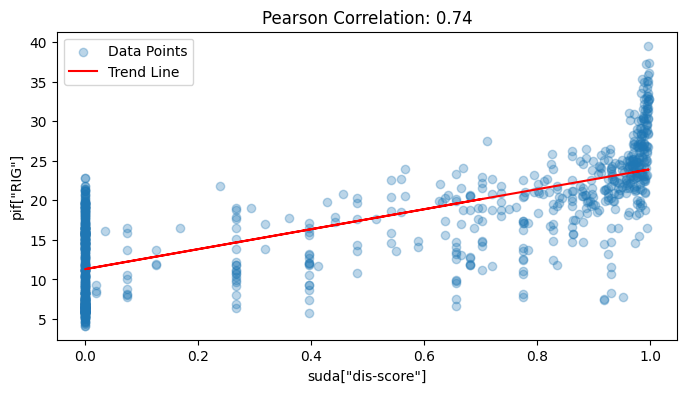

____________________________________________________________________________________

      FIELD LEVEL CORRELATIONS     

Pearson Correlation between SUDA & PIF field level: 0.77
Pearson Correlation between K-combined & PIF field level: 0.37
Pearson Correlation between SUDA & K-combined field level: -0.09


Spearman Rank Correlation between PIF & SUDA: 0.82
Spearman Rank Correlation between PIF & K: 0.11
Spearman Rank Correlation between SUDA & K: -0.01


In [407]:
stats(suda, pif, suda_field_score,k_combined_field)

# WHOLE DATASET RISK VALUE SUM

In [408]:
def convert_to_numeric(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category').cat.codes
    return df



def compute_suda2(dataframe, sample_fraction=0.2, missing_value=np.NaN):
    with localconverter(default_converter + pandas2ri.converter):
        r_df = robjects.conversion.py2rpy(dataframe)
        
    
    convert_to_numeric(dataframe) 
    
    suda_result = sdcMicro.suda2(r_df, missing=missing_value, DisFraction=sample_fraction)
    contribution_percent = list(suda_result.rx2('contributionPercent'))
    score = list(suda_result.rx2('score'))
    dis_score = list(suda_result.rx2('disScore'))

    return (contribution_percent, score, dis_score,suda_result)


In [409]:
import piflib.pif_calculator as pif
def calculate_sum(k_combined_all, AOMIC, sample_fraction=0.3, missing_value= np.nan):

    dis_scores = []
    pif_score = []
    
    k_combined_all = k_combined_all[k_combined_all['Combination'].str.count(',') >= 2]
    
    for index, row in k_combined_all.iterrows():
        combination_fields = row['Combination'].split(', ')
       
        df_subset = AOMIC[combination_fields]
        #df_subset = df_subset.fillna(-999)
        
        
        contribution_percent, score, dis_score, attribute_contributions = compute_suda2(
            df_subset, sample_fraction=sample_fraction, missing_value= missing_value)  
        
        
        
        summed_dis_score = sum(x for x in dis_score if not math.isnan(x))
        dis_scores.append(summed_dis_score)
        
        
        
        df_subset = df_subset.fillna(-999)
        
        cigs = piflib.compute_cigs(df_subset)
        
        pif_95 = pif.compute_pif(cigs, 0.95)
        pif_score.append(pif_95)
        
        
    
    k_combined_all['pif_score'] = pif_score
    k_combined_all['suda_score'] = dis_scores
    k_combined_all.fillna(0, inplace=True)
    k_combined_all.replace([np.inf, -np.inf], 0, inplace=True)

    return k_combined_all


In [410]:
sum_score_df = calculate_sum(k_combined_all, AOMIC, sample_fraction=0.3, missing_value= np.NaN)

In [392]:
def plot_correlation(k_combined_all): 
    
    #k_combined_all = k_combined_all.fillna(0)
    #k_combined_all = k_combined_all.replace([np.inf, -np.inf], 0)

    correlation, _ = spearmanr(k_combined_all['Score'], k_combined_all['suda_score'])
    print(f"Spearman Correlation between Suda sum and K-combined: {correlation:.2f}")
    
    pearson_corr = k_combined_all['Score'].corr(k_combined_all['suda_score'])
    print('Pearson correlation to Suda sum & K-combined',pearson_corr)
    
    print('________________________________________________________________________')
    
    print('Pearson Correlation:', pearson_corr)

    
    plt.figure(figsize=(8, 4))
    plt.scatter(k_combined_all['Score'], k_combined_all['suda_score'], alpha=0.6)
    plt.title(f'Scatter Plot of k-combined Score vs. SUDA Score\n(Pearson Correlation: {pearson_corr:.2f})')
    plt.xlabel('K-combined Score')
    plt.ylabel('SUDA Score')
    plt.grid(False)

    
    plt.show()
    
    print('________________________________________________________________________')
    print('\n')
    
    correlation, _ = spearmanr(k_combined_all['Score'], k_combined_all['pif_score'])
    print(f"Spearman Correlation between PIF 95% and K-combined: {correlation:.2f}")
    
    pearson_corr = k_combined_all['Score'].corr(k_combined_all['pif_score'])
    print('Pearson correlation to PIF 95% & K-combined',pearson_corr)
    
    plt.figure(figsize=(8, 4))
    plt.scatter(k_combined_all['Score'], k_combined_all['pif_score'], alpha=0.6)
    plt.title(f'Scatter Plot of k-combined Score vs. Pif score\n(Pearson Correlation: {pearson_corr:.2f})')
    plt.xlabel('K-combined Score')
    plt.ylabel('Pif score')
    plt.grid(False)

    
    plt.show()
    
    print('________________________________________________________________________')
    print('\n')
    
    correlation, _ = spearmanr(k_combined_all['suda_score'], k_combined_all['pif_score'])
    print(f"Spearman Correlation between PIF 95% and SUDA: {correlation:.2f}")
    
    pearson_corr = k_combined_all['suda_score'].corr(k_combined_all['pif_score'])
    print('Pearson correlation to PIF 95% & SUDA',pearson_corr)
    
    plt.figure(figsize=(8, 4))
    plt.scatter(k_combined_all['suda_score'], k_combined_all['pif_score'], alpha=0.6)
    plt.title(f'Scatter Plot of suda Score vs. Pif score\n(Pearson Correlation: {pearson_corr:.2f})')
    plt.xlabel('suda Score')
    plt.ylabel('Pif score')
    plt.grid(False)
        
        
    return 



Spearman Correlation between Suda sum and K-combined: -0.57
Pearson correlation to Suda sum & K-combined -0.1575652872939514
________________________________________________________________________
Pearson Correlation: -0.1575652872939514


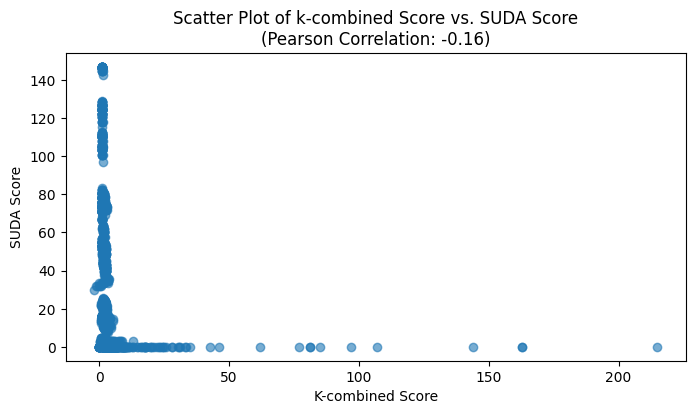

________________________________________________________________________


Spearman Correlation between PIF 95% and K-combined: -0.59
Pearson correlation to PIF 95% & K-combined -0.25327000411583034


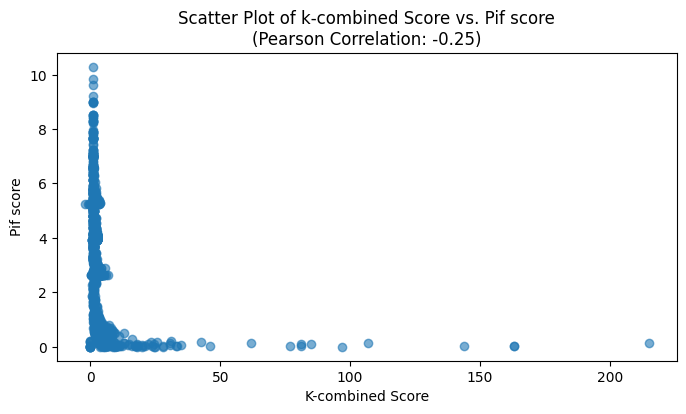

________________________________________________________________________


Spearman Correlation between PIF 95% and SUDA: 0.91
Pearson correlation to PIF 95% & SUDA 0.8284800859022818


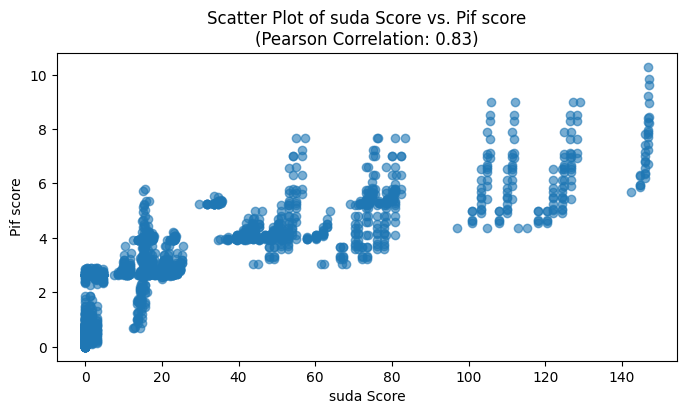

In [393]:
plot_correlation(sum_score_df)